In [1]:
from _operator import attrgetter
import math

from PIL import Image, ImageColor
import IPython.display

from Position import Position
from Piece import Piece
from Board import Board
from Game import Game
import random


# See Game.py to check, how an implementation of a bot should look like so that it can play games in Engine

# A simple bot, which chooses the first white piece and moves it one field forward-right,
# without checking if it's a correct move.
# It usually looses after a few moves when it attempts to make an incorrect move
class SampleBot:
    def make_move(self, board):
        piece = board.whites[0]
        return [piece.position(), piece.position().add(1, 1)]


class SampleBotOne:
    def make_move(self, board):
        if len(board.whites) > 0:
            piece = board.whites[1]
        else:
            piece = board.whites[0]
        return [piece.position(), piece.position().add(1, 1)]

class AlfaBetaBot0:
    def __init__(self, max_depth):
        self.max_depth = max_depth
    def heuristic_state_value(self, board):
        white_kings = 0.0
        black_kings = 0.0
        for white in board.whites:
            white_kings += white.king
        for black in board.blacks:
            black_kings += black.king
        kings = black_kings + white_kings
        return (len(board.whites) + white_kings) / (len(board.whites) + len(board.blacks) + kings)

    def alfa_beta(self, board, depth = 0, best = 0.0, worse = 1.0):
        if depth == self.max_depth:
            return self.heuristic_state_value(board)
        if depth % 2 == 0:
            value = 0.0
            res_move = []
            sorted_moves = ((self.heuristic_state_value(board.make_move(move)), move) for move in board.possible_moves())
            sorted_moves = sorted(sorted_moves, key=lambda x: 1 - x[0])
            for (_, move) in sorted_moves:
                child_value = self.alfa_beta(board.make_move(move), depth + 1, best, worse)
                best = max(best, child_value)
                if child_value >= worse:
                    value = child_value
                    res_move = move
                    break
                if child_value >= value:
                    if child_value > value or len(res_move) == 0:
                        res_move = move
                    value = child_value
        else:
            value = 1.0
            res_move = []
            sorted_moves = ((self.heuristic_state_value(board.make_move(move)), move) for move in board.possible_moves())
            sorted_moves = sorted(sorted_moves, key=lambda x: x[0])
            for (_, move) in sorted_moves:
                child_value = self.alfa_beta(board.make_move(move), depth + 1, best, worse)
                worse = min(worse, child_value)
                if child_value <= best:
                    value = child_value
                    res_move = move
                    break
                if child_value <= value:
                    if child_value < value or len(res_move) == 0:
                        res_move = move
                    value = child_value
        if depth == 0:
            return res_move
        return value
    def make_move(self, state):
        return self.alfa_beta(state)

class AlfaBetaBot:
    def __init__(self):
        self.max_depth = 4
    def heuristic_state_value(self, board):
        score = 0
        num_pieces = 0
        for white in board.whites:
            num_pieces += 1
            score += 5
            if white.king:
                score += 20
            else:
                score += white.y/15
        for black in board.blacks:
            num_pieces += 1
            score -= 5
            if black.king:
                score -= 20
            else:
                score -= black.y/15
        return score / num_pieces
    def possible_captures(self, board, king, position, captures_moves_list):
        ans = []
        if not king:
            possible_y = [1]
            if len(captures_moves_list) > 1:
                possible_y.append(-1)
            for j in possible_y:
                for i in [-1, 1]:
                    if board.isBlack(position.add(j, i)):
                        if board.isEmpty(position.add(j * 2, 2 * i)):
                            new_position = position.add(j * 2, 2 * i)
                            new_board = board.make_single_move(position, new_position, True, False)
                            captures_moves_list.append(new_position)
                            ans += [captures_moves_list.copy()]
                            ans += self.possible_captures(new_board, king, new_position, captures_moves_list)
                            captures_moves_list.pop()

        else:
            for xi in [-1, 1]:
                for yi in [-1, 1]:
                    where = position.add(yi, xi)
                    while board.isEmpty(where):
                        where = where.add(yi, xi)
                    if board.isBlack(where) and board.isEmpty(where.add(yi, xi)):
                        where = where.add(yi, xi)
                        new_position = where
                        while board.isEmpty(where):
                            ans += [captures_moves_list + [where]]
                            where = where.add(yi, xi)
                        new_board = board.make_single_move(position, new_position, True, False)
                        captures_moves_list.append(new_position)
                        ans += self.possible_captures(new_board, king, new_position, captures_moves_list)
                        captures_moves_list.pop()
        return ans

    def possible_moves(self, board):
        moves = []
        if board.capture_possible():
            for white in board.whites:
                moves += self.possible_captures(board, white.king, white.position(), [white.position()])
        else:
            for white in board.whites:
                if not white.king:
                    for i in [-1, 1]:
                        if board.isEmpty(white.position().add(1, i)):
                            moves += [[white.position(), white.position().add(1, i)]]
                else:
                    for xi in [-1, 1]:
                        for yi in [-1, 1]:
                            where = white.position().add(yi, xi)
                            while board.isEmpty(where):
                                moves += [[white.position(), where]]
                                where = where.add(yi, xi)
        return moves

    def alfa_beta_first(self, board):
        sorted_moves = [(self.heuristic_state_value(board.make_move(move)), move) for move in self.possible_moves(board)]
        sorted_moves.sort(key=lambda x: (x[0] * (-1)))
        value = -float("inf")
        res_move = []
        for (_, move) in sorted_moves:
            child_value = self.alfa_beta(board.make_move(move), 1, value)
            if child_value > value:
                res_move = move
                value = child_value
        return res_move

    def alfa_beta(self, board, depth = 0, best = -float("inf"), worse = float("inf")):
        if depth == self.max_depth:
            return self.heuristic_state_value(board)
        if depth % 2 == 0:
            value = -float("inf")
            for move in self.possible_moves(board):
                child_value = self.alfa_beta(board.make_move(move), depth + 1, best, worse)
                best = max(best, child_value)
                value = max(value, child_value)
                if best >= worse:
                    break
        else:
            value = float("inf")
            for move in self.possible_moves(board):
                child_value = self.alfa_beta(board.make_move(move), depth + 1, best, worse)
                worse = min(worse, child_value)
                value = min(value, child_value)
                if best >= worse:
                    break
        return value
    def make_move(self, state):
        return self.alfa_beta_first(state)

class MinMaxBot:
    def __init__(self, max_depth):
        self.max_depth = max_depth
    def heuristic_state_value(self, board):
        return len(board.whites) / (len(board.whites) + len(board.blacks))
    def min_max(self, board, depth):
        if depth == self.max_depth:
            return 1 - self.heuristic_state_value(board)
        value = 0
        res_move = []
        for move in board.possible_moves():
            child_value = 1 - self.min_max(board.make_move(move), depth + 1)
            if child_value >= value:
                value = child_value
                if child_value > value or len(res_move) == 0 or random.randint(1, 10) > 5:
                    res_move = move
        if depth == 0:
            return res_move
        return value
    def make_move(self, state):
        return self.min_max(state, 0)
# moves = board.possible_moves()
# for move in moves:
#     print(move)
#     board.revert().show()
#     board.make_move(move).show()

In [2]:
# # Suppose you have a class SampleBot and want to play againt it. Run:
# bot = MinMaxBot(4)
# game = Game(bot, None)
# game.play_human(False, True)

# When you are asked to specify your move in a textfield, specify it similarly as in a bot.
# However, don't wrap the locations into Positions class or a list - just list the numbers.
# For instance, to move from position (2, 0) to position (3, 1) just type: 2 0 3 1
# Also, remember that we firstly specify the row number and then the column number
# and that the upper-left field is (0, 0)
# board = Board()
# board = board.empty_board()
# board.world[1][3] = board.newWhite(1,3, True)
# board.world[2][2] = board.newBlack(2,2)
# board.world[2][4] = board.newBlack(2,4)
# board.world[4][4] = board.newBlack(4,4)
# board.world[4][2] = board.newBlack(4,2)
# moves = board.possible_moves()
# for move in moves:
#     board.revert().show()
#     board.make_move(move).show()

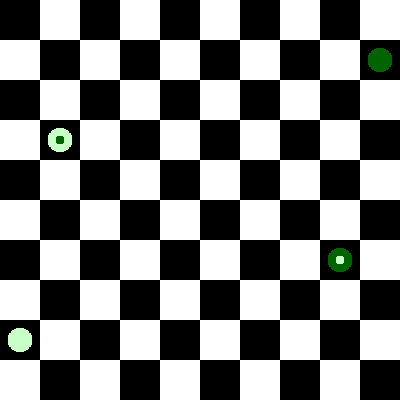

draw


RuntimeError: No active exception to reraise

In [3]:
# # Suppose you have classes SampleBot, SampleBotOne and want them to play against each other. Run:
# board = Board()
# board = board.empty_board()
# board.world[1][3] = board.newBlack(1,3, True)
# board.world[1][5] = board.newWhite(1,5, True)
# board.world[1][5] = board.newWhite(1,7)
bot = AlfaBetaBot()
botOne = AlfaBetaBot()
game = Game(botOne, bot)
game.play_bots()
# w = 0
# b = 0
# for x in range(1, 10):
#     game = Game(bot, botOne)
#     game.play_bots()
#     # if res['winner'] == 'white':
#     #     w += 1
#     # else:
#     #     b += 1
#     print(w)
#     print(b)
